In [69]:
! pip install ray
! pip install tensorboardX


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.5 MB/s eta 0:00:00


In [3]:

from functools import partial
import os
import tempfile
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from  torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import ray
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle



In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5,  l1)
        self.fc2 = nn.Linear( l1,  l2)
        self.fc3 = nn.Linear( l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [5]:
def load_data(data_dir="./data"):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform
    )

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform
    )

    return trainset, testset

In [6]:
# print size of images
trainset, testset = load_data()
print(trainset[0][0].size())

# print number of classes
print(len(trainset.classes))

100%|██████████| 170498071/170498071 [00:03<00:00, 44121701.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([3, 32, 32])
10


In [13]:
def train_cifar(config, data_dir="./data", NetConfig=None):
    try:

      if NetConfig is None:
        net = Net(config["l1"], config["l2"])
      else:
        net = FlexibleNet(NetConfig)
      device = "cpu"
      if torch.cuda.is_available():
          device = "cuda:0"
          if torch.cuda.device_count() > 1:
              net = nn.DataParallel(net)
      net.to(device)
      if config['optimizer'] == 'sgd':
          optimizer = optim.SGD(net.parameters(), lr=config['learning_rate'], momentum=config['momentum'], weight_decay=config['weight_decay'])
      elif config['optimizer'] == 'adam':
          optimizer = optim.Adam(net.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
      criterion = nn.CrossEntropyLoss()

      #centeron options
      if config['criterion'] == 'CrossEntropyLoss':
          criterion = nn.CrossEntropyLoss()
      elif config['criterion'] == 'NLLLoss':
          criterion = nn.NLLLoss()
      elif config['criterion'] == 'BCELoss':
          criterion = nn.BCELoss()
      elif config['criterion'] == 'MSELoss':
          criterion = nn.MSELoss()
      elif config['criterion'] == 'SoftMarginLoss':
          criterion = nn.SoftMarginLoss()

      checkpoint = get_checkpoint()
      if checkpoint:
          with checkpoint.as_directory() as checkpoint_dir:
              data_path = Path(checkpoint_dir) / "data.pkl"
              with open(data_path, "rb") as fp:
                  checkpoint_state = pickle.load(fp)
              start_epoch = checkpoint_state["epoch"]
              net.load_state_dict(checkpoint_state["net_state_dict"])
              optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
      else:
          start_epoch = 0

      trainset, testset = load_data(data_dir)

      test_abs = int(len(trainset) * 0.8)
      train_subset, val_subset = random_split(
          trainset, [test_abs, len(trainset) - test_abs]
      )

      trainloader = torch.utils.data.DataLoader(
          train_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=8
      )
      valloader = torch.utils.data.DataLoader(
          val_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=8
      )

      for epoch in range(start_epoch, 10):  # loop over the dataset multiple times
          running_loss = 0.0
          epoch_steps = 0
          for i, data in enumerate(trainloader, 0):
              # get the inputs; data is a list of [inputs, labels]
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              outputs = net(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

              # print statistics
              running_loss += loss.item()
              epoch_steps += 1
              if i % 2000 == 1999:  # print every 2000 mini-batches
                  print(
                      "[%d, %5d] loss: %.3f"
                      % (epoch + 1, i + 1, running_loss / epoch_steps)
                  )
                  running_loss = 0.0

          # Validation loss
          net.eval()
          val_loss = 0.0
          val_steps = 0
          total = 0
          correct = 0
          for i, data in enumerate(valloader, 0):
              with torch.no_grad():
                  inputs, labels = data
                  inputs, labels = inputs.to(device), labels.to(device)

                  outputs = net(inputs)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

                  loss = criterion(outputs, labels)

                  val_loss += loss.cpu().numpy()
                  val_steps += 1

          checkpoint_data = {
              "epoch": epoch,
              "net_state_dict": net.state_dict(),
              "optimizer_state_dict": optimizer.state_dict(),
          }
          with tempfile.TemporaryDirectory() as checkpoint_dir:
              data_path = Path(checkpoint_dir) / "data.pkl"
              with open(data_path, "wb") as fp:
                  pickle.dump(checkpoint_data, fp)

              checkpoint = Checkpoint.from_directory(checkpoint_dir)
              train.report(
                  {"loss": val_loss / val_steps, "accuracy": correct / total},
                  checkpoint=checkpoint,
              )


          print("Finished Training")

    except Exception as e:
        print(f"Error during training: {e}")
        raise

In [8]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2
    )

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [17]:
config = {
    'learning_rate': tune.loguniform(1e-4, 1e-1),
    'batch_size': tune.choice([16, 32, 64, 128]),
    'epochs': tune.choice([5, 10, 20]),
    'optimizer': tune.choice(['sgd', 'adam']),
    'momentum': tune.uniform(0.5, 0.9),
    'weight_decay': tune.loguniform(1e-4, 1e-2),
    'l1': tune.choice([120, 240, 360]),
    'l2': tune.choice([84, 168, 252]),
    'criterion': tune.choice(['CrossEntropyLoss', 'NLLLoss']) # , 'BCELoss', 'MSELoss', 'SoftMarginLoss'

    }

In [21]:
def train_hyper_param(num_samples=20, max_num_epochs=10, gpus_per_trial=1):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 12, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
    )
# Error during training: 'function' object has no attribute 'report'
    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")
    print(best_trial.last_result)

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])
        test_acc = test_accuracy(best_trained_model, device)
        print("Best trial test set accuracy: {}".format(test_acc))
ray.shutdown()
ray.init()
train_hyper_param()


2024-06-08 23:45:39,922	INFO worker.py:1753 -- Started a local Ray instance.


Files already downloaded and verified
Files already downloaded and verified


2024-06-08 23:45:42,436	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2024-06-08_23-45-42   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 20                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2024-06-08_23-45-42

Trial status: 20 PENDING
Current time: 2024-06-08 23:45:42. Total running time: 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     batch_size     epochs   optimizer       mo

(func pid=68897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0001,momentum=0.6912,op_2024-06-08_23-45-42/checkpoint_000000)


(func pid=68897) [2,  2000] loss: 2.300

Trial train_cifar_37be9_00000 finished iteration 2 at 2024-06-08 23:46:10. Total running time: 28s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                  10.89398 |
| time_total_s                                      24.18583 |
| training_iteration                                       2 |
| accuracy                                            0.1091 |
| loss                                                 2.299 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00000 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate

(func pid=68897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0001,momentum=0.6912,op_2024-06-08_23-45-42/checkpoint_000001)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2024-06-08 23:46:12. Total running time: 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)     loss     accuracy |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00000   RUNNING        0.000127904             16         10   sgd             0.691209      0.00303265     360    252   CrossEntropyLoss        2            24.1858    2.299

(func pid=68897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0001,momentum=0.6912,op_2024-06-08_23-45-42/checkpoint_000002)


(func pid=68897) [4,  2000] loss: 2.294

Trial train_cifar_37be9_00000 finished iteration 4 at 2024-06-08 23:46:32. Total running time: 50s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                  10.86382 |
| time_total_s                                      46.10683 |
| training_iteration                                       4 |
| accuracy                                            0.1583 |
| loss                                               2.28995 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00000 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate

(func pid=68897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0001,momentum=0.6912,op_2024-06-08_23-45-42/checkpoint_000003)


(func pid=68897) [5,  2000] loss: 2.286

Trial status: 1 RUNNING | 19 PENDING
Current time: 2024-06-08 23:46:42. Total running time: 1min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)      loss     accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00000   RUNNING        0.000127904             16         10   sgd             0.691209      0.00303265     360    252   CrossE

(func pid=68897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0001,momentum=0.6912,op_2024-06-08_23-45-42/checkpoint_000004)


(func pid=68897) [6,  2000] loss: 2.269

Trial train_cifar_37be9_00000 finished iteration 6 at 2024-06-08 23:46:54. Total running time: 1min 11s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                  10.62885 |
| time_total_s                                      67.39358 |
| training_iteration                                       6 |
| accuracy                                             0.178 |
| loss                                               2.25007 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00000 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning

(func pid=68897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0001,momentum=0.6912,op_2024-06-08_23-45-42/checkpoint_000005)


(func pid=68897) [7,  2000] loss: 2.238

Trial train_cifar_37be9_00000 finished iteration 7 at 2024-06-08 23:47:05. Total running time: 1min 22s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                  11.07846 |
| time_total_s                                      78.47204 |
| training_iteration                                       7 |
| accuracy                                            0.2049 |
| loss                                               2.21627 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00000 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning

(func pid=68897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0001,momentum=0.6912,op_2024-06-08_23-45-42/checkpoint_000006)


(func pid=68897) [8,  2000] loss: 2.206

Trial status: 1 RUNNING | 19 PENDING
Current time: 2024-06-08 23:47:12. Total running time: 1min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status       learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)      loss     accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00000   RUNNING        0.000127904             16         10   sgd             0.691209      0.00303265     360    252   Cross

(func pid=68897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0001,momentum=0.6912,op_2024-06-08_23-45-42/checkpoint_000007)


(func pid=68897) [9,  2000] loss: 2.165

Trial train_cifar_37be9_00000 finished iteration 9 at 2024-06-08 23:47:26. Total running time: 1min 44s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                    10.778 |
| time_total_s                                      99.99726 |
| training_iteration                                       9 |
| accuracy                                            0.2445 |
| loss                                               2.12976 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00000 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning

(func pid=68897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0001,momentum=0.6912,op_2024-06-08_23-45-42/checkpoint_000008)


(func pid=68897) [10,  2000] loss: 2.113

Trial train_cifar_37be9_00000 finished iteration 10 at 2024-06-08 23:47:37. Total running time: 1min 55s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00000 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                  10.94351 |
| time_total_s                                     110.94077 |
| training_iteration                                      10 |
| accuracy                                            0.2497 |
| loss                                               2.08142 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00000 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learn

(func pid=68897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00000_0_batch_size=16,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0001,momentum=0.6912,op_2024-06-08_23-45-42/checkpoint_000009)



Trial train_cifar_37be9_00001 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00001 config                      |
+-----------------------------------------------------------+
| batch_size                                            128 |
| criterion                                CrossEntropyLoss |
| epochs                                                  5 |
| l1                                                    360 |
| l2                                                    168 |
| learning_rate                                     0.00069 |
| momentum                                          0.51486 |
| optimizer                                             sgd |
| weight_decay                                      0.00176 |
+-----------------------------------------------------------+
(func pid=71931) Files already downloaded and verified

Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2024-06-08 23

(func pid=71931) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=71931)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00001 finished iteration 1 at 2024-06-08 23:47:47. Total running time: 2min 5s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00001 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   5.35428 |
| time_total_s                                       5.35428 |
| training_iteration                                       1 |
| accuracy                                            0.1098 |
| loss                                               2.30277 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00001 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00001_1_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0007,momentum=0.5149,op_2024-06-0

(func pid=71931) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00001_1_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0007,momentum=0.5149,op_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00002 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00002 config                      |
+-----------------------------------------------------------+
| batch_size                                            128 |
| criterion                                CrossEntropyLoss |
| epochs                                                  5 |
| l1                                                    360 |
| l2                                                    168 |
| learning_rate                                     0.04212 |
| momentum                                          0.50444 |
| optimizer                                             sgd |
| weight_decay                                      0.00483 |
+-----------------------------------------------------------+
(func pid=72336) Files already downloaded and verified
(func pid=72336) Files already downloaded and verified


(func pid=72336) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=72336)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00002 finished iteration 1 at 2024-06-08 23:47:57. Total running time: 2min 15s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   5.24203 |
| time_total_s                                       5.24203 |
| training_iteration                                       1 |
| accuracy                                            0.3321 |
| loss                                               1.80362 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00002 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-

(func pid=72336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00002 finished iteration 2 at 2024-06-08 23:48:00. Total running time: 2min 18s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   3.01482 |
| time_total_s                                       8.25685 |
| training_iteration                                       2 |
| accuracy                                            0.4465 |
| loss                                               1.51199 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00002 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-

(func pid=72336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-08_23-45-42/checkpoint_000001)



Trial train_cifar_37be9_00002 finished iteration 3 at 2024-06-08 23:48:03. Total running time: 2min 21s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   3.14053 |
| time_total_s                                      11.39738 |
| training_iteration                                       3 |
| accuracy                                            0.5044 |
| loss                                               1.38639 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00002 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-

(func pid=72336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-08_23-45-42/checkpoint_000002)



Trial train_cifar_37be9_00002 finished iteration 4 at 2024-06-08 23:48:06. Total running time: 2min 24s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   3.04449 |
| time_total_s                                      14.44187 |
| training_iteration                                       4 |
| accuracy                                            0.4876 |
| loss                                               1.43508 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00002 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-

(func pid=72336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-08_23-45-42/checkpoint_000003)



Trial train_cifar_37be9_00002 finished iteration 5 at 2024-06-08 23:48:09. Total running time: 2min 27s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   3.00691 |
| time_total_s                                      17.44878 |
| training_iteration                                       5 |
| accuracy                                            0.5347 |
| loss                                               1.31026 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00002 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-

(func pid=72336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-08_23-45-42/checkpoint_000004)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2024-06-08 23:48:13. Total running time: 2min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)      loss     accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00002   RUNNING          0.0421174              128          5   sgd             0.504435      0.00482545     360    168   CrossEntropyLoss      

(func pid=72336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-08_23-45-42/checkpoint_000005)



Trial train_cifar_37be9_00002 finished iteration 7 at 2024-06-08 23:48:16. Total running time: 2min 33s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   3.06057 |
| time_total_s                                      23.68013 |
| training_iteration                                       7 |
| accuracy                                            0.5619 |
| loss                                               1.23686 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00002 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-

(func pid=72336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-08_23-45-42/checkpoint_000006)



Trial train_cifar_37be9_00002 finished iteration 8 at 2024-06-08 23:48:19. Total running time: 2min 36s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   3.09441 |
| time_total_s                                      26.77454 |
| training_iteration                                       8 |
| accuracy                                            0.5864 |
| loss                                               1.17862 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00002 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-

(func pid=72336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-08_23-45-42/checkpoint_000007)



Trial train_cifar_37be9_00002 finished iteration 9 at 2024-06-08 23:48:22. Total running time: 2min 39s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   3.00668 |
| time_total_s                                      29.78122 |
| training_iteration                                       9 |
| accuracy                                            0.5742 |
| loss                                               1.20578 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00002 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-

(func pid=72336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-08_23-45-42/checkpoint_000008)



Trial train_cifar_37be9_00002 finished iteration 10 at 2024-06-08 23:48:25. Total running time: 2min 42s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00002 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   3.03219 |
| time_total_s                                      32.81341 |
| training_iteration                                      10 |
| accuracy                                            0.5682 |
| loss                                               1.19385 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00002 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-0

(func pid=72336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00002_2_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=360,l2=168,learning_rate=0.0421,momentum=0.5044,op_2024-06-08_23-45-42/checkpoint_000009)



Trial train_cifar_37be9_00003 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_37be9_00003 config             |
+--------------------------------------------------+
| batch_size                                    32 |
| criterion                                NLLLoss |
| epochs                                        10 |
| l1                                           120 |
| l2                                           168 |
| learning_rate                            0.02052 |
| momentum                                 0.63736 |
| optimizer                                    sgd |
| weight_decay                             0.00012 |
+--------------------------------------------------+
(func pid=75022) Files already downloaded and verified
(func pid=75022) Files already downloaded and verified

Trial train_cifar_37be9_00003 finished iteration 1 at 2024-06-08 23:48:38. Total running time: 2min 56s
+------------------------------------

(func pid=75022) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-08_23-45-42/checkpoint_000000)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2024-06-08 23:48:43. Total running time: 3min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00003   RUNNING          0.0205216               32         10   sgd             0.637362      0.000116181    120    168   NLLLoss          

(func pid=75022) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-08_23-45-42/checkpoint_000001)



Trial train_cifar_37be9_00003 finished iteration 3 at 2024-06-08 23:48:51. Total running time: 3min 8s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   6.21108 |
| time_total_s                                      20.74581 |
| training_iteration                                       3 |
| accuracy                                            0.1025 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00003 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-0

(func pid=75022) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-08_23-45-42/checkpoint_000002)



Trial train_cifar_37be9_00003 finished iteration 4 at 2024-06-08 23:48:57. Total running time: 3min 14s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   6.25246 |
| time_total_s                                      26.99827 |
| training_iteration                                       4 |
| accuracy                                            0.1025 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00003 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-

(func pid=75022) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-08_23-45-42/checkpoint_000003)



Trial train_cifar_37be9_00003 finished iteration 5 at 2024-06-08 23:49:03. Total running time: 3min 20s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   5.79839 |
| time_total_s                                      32.79666 |
| training_iteration                                       5 |
| accuracy                                            0.1025 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00003 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-

(func pid=75022) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-08_23-45-42/checkpoint_000004)



Trial train_cifar_37be9_00003 finished iteration 6 at 2024-06-08 23:49:09. Total running time: 3min 26s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   6.16735 |
| time_total_s                                        38.964 |
| training_iteration                                       6 |
| accuracy                                            0.1025 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00003 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-

(func pid=75022) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-08_23-45-42/checkpoint_000005)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2024-06-08 23:49:13. Total running time: 3min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00003   RUNNING          0.0205216               32         10   sgd             0.637362      0.000116181    120    168   NLLLoss         

(func pid=75022) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-08_23-45-42/checkpoint_000006)



Trial train_cifar_37be9_00003 finished iteration 8 at 2024-06-08 23:49:21. Total running time: 3min 39s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   6.24076 |
| time_total_s                                      51.40938 |
| training_iteration                                       8 |
| accuracy                                            0.1025 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00003 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-

(func pid=75022) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-08_23-45-42/checkpoint_000007)



Trial train_cifar_37be9_00003 finished iteration 9 at 2024-06-08 23:49:28. Total running time: 3min 45s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   6.27007 |
| time_total_s                                      57.67945 |
| training_iteration                                       9 |
| accuracy                                            0.1025 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00003 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-

(func pid=75022) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-08_23-45-42/checkpoint_000008)



Trial train_cifar_37be9_00003 finished iteration 10 at 2024-06-08 23:49:34. Total running time: 3min 52s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00003 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   6.46663 |
| time_total_s                                      64.14608 |
| training_iteration                                      10 |
| accuracy                                            0.1025 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00003 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-0

(func pid=75022) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00003_3_batch_size=32,criterion=NLLLoss,epochs=10,l1=120,l2=168,learning_rate=0.0205,momentum=0.6374,optimizer=s_2024-06-08_23-45-42/checkpoint_000009)



Trial train_cifar_37be9_00004 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00004 config                      |
+-----------------------------------------------------------+
| batch_size                                             16 |
| criterion                                CrossEntropyLoss |
| epochs                                                  5 |
| l1                                                    240 |
| l2                                                     84 |
| learning_rate                                     0.00887 |
| momentum                                           0.7656 |
| optimizer                                             sgd |
| weight_decay                                      0.00426 |
+-----------------------------------------------------------+
(func pid=77847) Files already downloaded and verified
(func pid=77847) Files already downloaded and verified

Trial status: 4 TERMINAT

(func pid=77847) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0089,momentum=0.7656,opti_2024-06-08_23-45-42/checkpoint_000000)


(func pid=77847) [2,  2000] loss: 1.447

Trial train_cifar_37be9_00004 finished iteration 2 at 2024-06-08 23:50:02. Total running time: 4min 20s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00004 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                  10.54393 |
| time_total_s                                      23.47497 |
| training_iteration                                       2 |
| accuracy                                            0.4942 |
| loss                                               1.41643 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00004 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_r

(func pid=77847) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0089,momentum=0.7656,opti_2024-06-08_23-45-42/checkpoint_000001)


(func pid=77847) [3,  2000] loss: 1.315

Trial status: 4 TERMINATED | 1 RUNNING | 15 PENDING
Current time: 2024-06-08 23:50:13. Total running time: 4min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00004   RUNNING          0.00887431              16          5   sgd             0.765598      0.00

(func pid=77847) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0089,momentum=0.7656,opti_2024-06-08_23-45-42/checkpoint_000002)


(func pid=77847) [4,  2000] loss: 1.217

Trial train_cifar_37be9_00004 finished iteration 4 at 2024-06-08 23:50:24. Total running time: 4min 41s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00004 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                  10.54075 |
| time_total_s                                      44.68322 |
| training_iteration                                       4 |
| accuracy                                             0.588 |
| loss                                               1.18071 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00004 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_r

(func pid=77847) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0089,momentum=0.7656,opti_2024-06-08_23-45-42/checkpoint_000003)


(func pid=77847) [5,  2000] loss: 1.167

Trial train_cifar_37be9_00004 finished iteration 5 at 2024-06-08 23:50:34. Total running time: 4min 52s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00004 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                  10.43462 |
| time_total_s                                      55.11784 |
| training_iteration                                       5 |
| accuracy                                            0.5859 |
| loss                                                1.1656 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00004 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_r

(func pid=77847) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0089,momentum=0.7656,opti_2024-06-08_23-45-42/checkpoint_000004)


(func pid=77847) [6,  2000] loss: 1.113

Trial status: 4 TERMINATED | 1 RUNNING | 15 PENDING
Current time: 2024-06-08 23:50:43. Total running time: 5min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00004   RUNNING          0.00887431              16          5   sgd             0.765598      0.004

(func pid=77847) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0089,momentum=0.7656,opti_2024-06-08_23-45-42/checkpoint_000005)


(func pid=77847) [7,  2000] loss: 1.070

Trial train_cifar_37be9_00004 finished iteration 7 at 2024-06-08 23:50:55. Total running time: 5min 13s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00004 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                  10.70139 |
| time_total_s                                       76.3091 |
| training_iteration                                       7 |
| accuracy                                            0.5994 |
| loss                                               1.15163 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00004 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_r

(func pid=77847) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0089,momentum=0.7656,opti_2024-06-08_23-45-42/checkpoint_000006)


(func pid=77847) [8,  2000] loss: 1.046

Trial train_cifar_37be9_00004 finished iteration 8 at 2024-06-08 23:51:06. Total running time: 5min 24s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00004 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                  10.64908 |
| time_total_s                                      86.95818 |
| training_iteration                                       8 |
| accuracy                                            0.5407 |
| loss                                                  1.33 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00004 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_r

(func pid=77847) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0089,momentum=0.7656,opti_2024-06-08_23-45-42/checkpoint_000007)



Trial status: 4 TERMINATED | 1 RUNNING | 15 PENDING
Current time: 2024-06-08 23:51:13. Total running time: 5min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00004   RUNNING          0.00887431              16          5   sgd             0.765598      0.00426428     240     84   CrossEntropyLoss

(func pid=77847) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0089,momentum=0.7656,opti_2024-06-08_23-45-42/checkpoint_000008)


(func pid=77847) [10,  2000] loss: 1.005

Trial train_cifar_37be9_00004 finished iteration 10 at 2024-06-08 23:51:28. Total running time: 5min 45s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00004 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                  10.88329 |
| time_total_s                                     108.63408 |
| training_iteration                                      10 |
| accuracy                                            0.6253 |
| loss                                               1.07806 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00004 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learnin

(func pid=77847) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00004_4_batch_size=16,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0089,momentum=0.7656,opti_2024-06-08_23-45-42/checkpoint_000009)



Trial train_cifar_37be9_00005 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00005 config                      |
+-----------------------------------------------------------+
| batch_size                                            128 |
| criterion                                CrossEntropyLoss |
| epochs                                                 20 |
| l1                                                    240 |
| l2                                                     84 |
| learning_rate                                     0.02354 |
| momentum                                          0.76503 |
| optimizer                                            adam |
| weight_decay                                      0.00022 |
+-----------------------------------------------------------+
(func pid=80860) Files already downloaded and verified
(func pid=80860) Files already downloaded and verified


(func pid=80860) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=80860)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00005 finished iteration 1 at 2024-06-08 23:51:38. Total running time: 5min 56s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   5.39503 |
| time_total_s                                       5.39503 |
| training_iteration                                       1 |
| accuracy                                            0.2568 |
| loss                                               1.95539 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00005 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00005_5_batch_size=128,criterion=CrossEntropyLoss,epochs=20,l1=240,l2=84,learning_rate=0.0235,momentum=0.7650,op_2024-06-

(func pid=80860) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00005_5_batch_size=128,criterion=CrossEntropyLoss,epochs=20,l1=240,l2=84,learning_rate=0.0235,momentum=0.7650,op_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00005 finished iteration 2 at 2024-06-08 23:51:41. Total running time: 5min 59s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00005 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   3.13561 |
| time_total_s                                       8.53064 |
| training_iteration                                       2 |
| accuracy                                            0.2784 |
| loss                                               1.88868 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00005 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00005_5_batch_size=128,criterion=CrossEntropyLoss,epochs=20,l1=240,l2=84,learning_rate=0.0235,momentum=0.7650,op_2024-06-

(func pid=80860) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00005_5_batch_size=128,criterion=CrossEntropyLoss,epochs=20,l1=240,l2=84,learning_rate=0.0235,momentum=0.7650,op_2024-06-08_23-45-42/checkpoint_000001)



Trial status: 6 TERMINATED | 14 PENDING
Current time: 2024-06-08 23:51:43. Total running time: 6min 1s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00000   TERMINATED       0.000127904             16         10   sgd             0.691209      0.00303265     360    252   CrossEntropyLoss       10    

(func pid=81521) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00006_6_batch_size=32,criterion=CrossEntropyLoss,epochs=20,l1=360,l2=168,learning_rate=0.0897,momentum=0.6575,op_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00007 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_37be9_00007 config             |
+--------------------------------------------------+
| batch_size                                    16 |
| criterion                                NLLLoss |
| epochs                                        20 |
| l1                                           360 |
| l2                                            84 |
| learning_rate                            0.00014 |
| momentum                                 0.62569 |
| optimizer                                    sgd |
| weight_decay                             0.00141 |
+--------------------------------------------------+
(func pid=81943) Files already downloaded and verified
(func pid=81943) Files already downloaded and verified
(func pid=81943) [1,  2000] loss: 0.005

Trial train_cifar_37be9_00007 finished iteration 1 at 2024-06-08 23:52:13. Total running time: 6min 3

(func pid=81943) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001,momentum=0.6257,optimizer=sg_2024-06-08_23-45-42/checkpoint_000000)



Trial status: 7 TERMINATED | 1 RUNNING | 12 PENDING
Current time: 2024-06-08 23:52:13. Total running time: 6min 31s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)          loss     accuracy |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00007   RUNNING          0.000141282             16         20   sgd             0.625691      0.0014128      360     84   NLLLoss   

(func pid=81943) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001,momentum=0.6257,optimizer=sg_2024-06-08_23-45-42/checkpoint_000001)


(func pid=81943) [3,  2000] loss: nan

Trial train_cifar_37be9_00007 finished iteration 3 at 2024-06-08 23:52:34. Total running time: 6min 52s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                  10.65993 |
| time_total_s                                      34.28221 |
| training_iteration                                       3 |
| accuracy                                            0.1023 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00007 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001

(func pid=81943) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001,momentum=0.6257,optimizer=sg_2024-06-08_23-45-42/checkpoint_000002)


(func pid=81943) [4,  2000] loss: nan

Trial status: 7 TERMINATED | 1 RUNNING | 12 PENDING
Current time: 2024-06-08 23:52:43. Total running time: 7min 1s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00007   RUNNING          0.000141282             16         20   sgd             0.625691      0.00141

(func pid=81943) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001,momentum=0.6257,optimizer=sg_2024-06-08_23-45-42/checkpoint_000003)


(func pid=81943) [5,  2000] loss: nan

Trial train_cifar_37be9_00007 finished iteration 5 at 2024-06-08 23:52:55. Total running time: 7min 13s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                  10.49372 |
| time_total_s                                      55.43403 |
| training_iteration                                       5 |
| accuracy                                            0.1023 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00007 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001

(func pid=81943) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001,momentum=0.6257,optimizer=sg_2024-06-08_23-45-42/checkpoint_000004)


(func pid=81943) [6,  2000] loss: nan

Trial train_cifar_37be9_00007 finished iteration 6 at 2024-06-08 23:53:06. Total running time: 7min 24s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                  10.61659 |
| time_total_s                                      66.05063 |
| training_iteration                                       6 |
| accuracy                                            0.1023 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00007 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001

(func pid=81943) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001,momentum=0.6257,optimizer=sg_2024-06-08_23-45-42/checkpoint_000005)



Trial status: 7 TERMINATED | 1 RUNNING | 12 PENDING
Current time: 2024-06-08 23:53:13. Total running time: 7min 31s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00007   RUNNING          0.000141282             16         20   sgd             0.625691      0.0014128      360     84   NLLLoss         

(func pid=81943) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001,momentum=0.6257,optimizer=sg_2024-06-08_23-45-42/checkpoint_000006)


(func pid=81943) [8,  2000] loss: nan

Trial train_cifar_37be9_00007 finished iteration 8 at 2024-06-08 23:53:27. Total running time: 7min 45s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                  10.74446 |
| time_total_s                                      87.40864 |
| training_iteration                                       8 |
| accuracy                                            0.1023 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00007 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001

(func pid=81943) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001,momentum=0.6257,optimizer=sg_2024-06-08_23-45-42/checkpoint_000007)


(func pid=81943) [9,  2000] loss: nan

Trial train_cifar_37be9_00007 finished iteration 9 at 2024-06-08 23:53:38. Total running time: 7min 55s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                  10.41597 |
| time_total_s                                      97.82461 |
| training_iteration                                       9 |
| accuracy                                            0.1023 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00007 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001

(func pid=81943) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001,momentum=0.6257,optimizer=sg_2024-06-08_23-45-42/checkpoint_000008)



Trial status: 7 TERMINATED | 1 RUNNING | 12 PENDING
Current time: 2024-06-08 23:53:43. Total running time: 8min 1s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00007   RUNNING          0.000141282             16         20   sgd             0.625691      0.0014128      360     84   NLLLoss          

(func pid=81943) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00007_7_batch_size=16,criterion=NLLLoss,epochs=20,l1=360,l2=84,learning_rate=0.0001,momentum=0.6257,optimizer=sg_2024-06-08_23-45-42/checkpoint_000009)



Trial train_cifar_37be9_00008 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00008 config                      |
+-----------------------------------------------------------+
| batch_size                                            128 |
| criterion                                CrossEntropyLoss |
| epochs                                                 10 |
| l1                                                    120 |
| l2                                                    252 |
| learning_rate                                     0.01047 |
| momentum                                          0.63333 |
| optimizer                                            adam |
| weight_decay                                      0.00011 |
+-----------------------------------------------------------+
(func pid=84963) Files already downloaded and verified
(func pid=84963) Files already downloaded and verified


(func pid=84963) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=84963)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00008 finished iteration 1 at 2024-06-08 23:53:59. Total running time: 8min 17s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   5.30015 |
| time_total_s                                       5.30015 |
| training_iteration                                       1 |
| accuracy                                            0.3998 |
| loss                                               1.60569 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00008 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00008_8_batch_size=128,criterion=CrossEntropyLoss,epochs=10,l1=120,l2=252,learning_rate=0.0105,momentum=0.6333,o_2024-06-

(func pid=84963) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00008_8_batch_size=128,criterion=CrossEntropyLoss,epochs=10,l1=120,l2=252,learning_rate=0.0105,momentum=0.6333,o_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00008 finished iteration 2 at 2024-06-08 23:54:02. Total running time: 8min 20s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00008 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   3.10501 |
| time_total_s                                       8.40516 |
| training_iteration                                       2 |
| accuracy                                            0.4256 |
| loss                                               1.55373 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00008 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00008_8_batch_size=128,criterion=CrossEntropyLoss,epochs=10,l1=120,l2=252,learning_rate=0.0105,momentum=0.6333,o_2024-06-

(func pid=84963) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00008_8_batch_size=128,criterion=CrossEntropyLoss,epochs=10,l1=120,l2=252,learning_rate=0.0105,momentum=0.6333,o_2024-06-08_23-45-42/checkpoint_000001)



Trial train_cifar_37be9_00009 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_37be9_00009 config             |
+--------------------------------------------------+
| batch_size                                    32 |
| criterion                                NLLLoss |
| epochs                                        10 |
| l1                                           360 |
| l2                                           168 |
| learning_rate                            0.00011 |
| momentum                                 0.81054 |
| optimizer                                    sgd |
| weight_decay                             0.00059 |
+--------------------------------------------------+
(func pid=85620) Files already downloaded and verified
(func pid=85620) Files already downloaded and verified

Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-06-08 23:54:13. Total running time: 8min 31s
Logical resource usage: 1

(func pid=85620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00009 finished iteration 2 at 2024-06-08 23:54:22. Total running time: 8min 39s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   6.29384 |
| time_total_s                                      14.57105 |
| training_iteration                                       2 |
| accuracy                                            0.1006 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00009 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-

(func pid=85620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-08_23-45-42/checkpoint_000001)



Trial train_cifar_37be9_00009 finished iteration 3 at 2024-06-08 23:54:27. Total running time: 8min 45s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   5.90828 |
| time_total_s                                      20.47933 |
| training_iteration                                       3 |
| accuracy                                            0.1006 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00009 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-

(func pid=85620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-08_23-45-42/checkpoint_000002)



Trial train_cifar_37be9_00009 finished iteration 4 at 2024-06-08 23:54:34. Total running time: 8min 51s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   6.18231 |
| time_total_s                                      26.66164 |
| training_iteration                                       4 |
| accuracy                                            0.1006 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00009 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-

(func pid=85620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-08_23-45-42/checkpoint_000003)



Trial train_cifar_37be9_00009 finished iteration 5 at 2024-06-08 23:54:40. Total running time: 8min 57s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   6.17673 |
| time_total_s                                      32.83837 |
| training_iteration                                       5 |
| accuracy                                            0.1006 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00009 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-

(func pid=85620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-08_23-45-42/checkpoint_000004)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2024-06-08 23:54:43. Total running time: 9min 1s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00009   RUNNING          0.00011069              32         10   sgd             0.810543      0.00059152     360    168   NLLLoss          

(func pid=85620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-08_23-45-42/checkpoint_000005)



Trial train_cifar_37be9_00009 finished iteration 7 at 2024-06-08 23:54:52. Total running time: 9min 10s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   6.16578 |
| time_total_s                                      45.32444 |
| training_iteration                                       7 |
| accuracy                                            0.1006 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00009 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-

(func pid=85620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-08_23-45-42/checkpoint_000006)



Trial train_cifar_37be9_00009 finished iteration 8 at 2024-06-08 23:54:59. Total running time: 9min 16s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                    6.1837 |
| time_total_s                                      51.50814 |
| training_iteration                                       8 |
| accuracy                                            0.1006 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00009 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-

(func pid=85620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-08_23-45-42/checkpoint_000007)



Trial train_cifar_37be9_00009 finished iteration 9 at 2024-06-08 23:55:05. Total running time: 9min 22s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                   6.11328 |
| time_total_s                                      57.62142 |
| training_iteration                                       9 |
| accuracy                                            0.1006 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00009 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-

(func pid=85620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-08_23-45-42/checkpoint_000008)



Trial train_cifar_37be9_00009 finished iteration 10 at 2024-06-08 23:55:11. Total running time: 9min 28s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00009 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   5.98856 |
| time_total_s                                      63.60997 |
| training_iteration                                      10 |
| accuracy                                            0.1006 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00009 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-0

(func pid=85620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00009_9_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0001,momentum=0.8105,optimizer=s_2024-06-08_23-45-42/checkpoint_000009)



Trial status: 10 TERMINATED | 10 PENDING
Current time: 2024-06-08 23:55:13. Total running time: 9min 31s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)        loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00000   TERMINATED       0.000127904             16         10   sgd             0.691209      0.00303265     360    252   CrossEntropyLoss       10  

(func pid=88441) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=88441)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00010 finished iteration 1 at 2024-06-08 23:55:21. Total running time: 9min 39s
+---------------------------------------------------------------+
| Trial train_cifar_37be9_00010 result                          |
+---------------------------------------------------------------+
| checkpoint_dir_name                         checkpoint_000000 |
| time_this_iter_s                                      5.29557 |
| time_total_s                                          5.29557 |
| training_iteration                                          1 |
| accuracy                                               0.0984 |
| loss                                     -496101234384170.125 |
+---------------------------------------------------------------+
Trial train_cifar_37be9_00010 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momen

(func pid=88441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133,optimizer=_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00010 finished iteration 2 at 2024-06-08 23:55:24. Total running time: 9min 42s
+--------------------------------------------------------------+
| Trial train_cifar_37be9_00010 result                         |
+--------------------------------------------------------------+
| checkpoint_dir_name                        checkpoint_000001 |
| time_this_iter_s                                     3.16734 |
| time_total_s                                         8.46291 |
| training_iteration                                         2 |
| accuracy                                               0.102 |
| loss                                     -29020258783849616. |
+--------------------------------------------------------------+
Trial train_cifar_37be9_00010 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133

(func pid=88441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133,optimizer=_2024-06-08_23-45-42/checkpoint_000001)



Trial train_cifar_37be9_00010 finished iteration 3 at 2024-06-08 23:55:28. Total running time: 9min 45s
+---------------------------------------------------------------+
| Trial train_cifar_37be9_00010 result                          |
+---------------------------------------------------------------+
| checkpoint_dir_name                         checkpoint_000002 |
| time_this_iter_s                                      3.08564 |
| time_total_s                                         11.54856 |
| training_iteration                                          3 |
| accuracy                                                0.102 |
| loss                                     -254138952763160768. |
+---------------------------------------------------------------+
Trial train_cifar_37be9_00010 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momen

(func pid=88441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133,optimizer=_2024-06-08_23-45-42/checkpoint_000002)



Trial train_cifar_37be9_00010 finished iteration 4 at 2024-06-08 23:55:31. Total running time: 9min 48s
+----------------------------------------------------------------+
| Trial train_cifar_37be9_00010 result                           |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000003 |
| time_this_iter_s                                       3.25745 |
| time_total_s                                          14.80601 |
| training_iteration                                           4 |
| accuracy                                                 0.102 |
| loss                                     -1092013456038373888. |
+----------------------------------------------------------------+
Trial train_cifar_37be9_00010 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.

(func pid=88441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133,optimizer=_2024-06-08_23-45-42/checkpoint_000003)



Trial train_cifar_37be9_00010 finished iteration 5 at 2024-06-08 23:55:34. Total running time: 9min 52s
+----------------------------------------------------------------+
| Trial train_cifar_37be9_00010 result                           |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000004 |
| time_this_iter_s                                       3.26874 |
| time_total_s                                          18.07475 |
| training_iteration                                           5 |
| accuracy                                                0.0984 |
| loss                                     -3222469437187075584. |
+----------------------------------------------------------------+
Trial train_cifar_37be9_00010 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.

(func pid=88441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133,optimizer=_2024-06-08_23-45-42/checkpoint_000004)



Trial train_cifar_37be9_00010 finished iteration 6 at 2024-06-08 23:55:37. Total running time: 9min 55s
+----------------------------------------------------------------+
| Trial train_cifar_37be9_00010 result                           |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000005 |
| time_this_iter_s                                       3.21625 |
| time_total_s                                            21.291 |
| training_iteration                                           6 |
| accuracy                                                 0.102 |
| loss                                     -7618713298977337344. |
+----------------------------------------------------------------+
Trial train_cifar_37be9_00010 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.

(func pid=88441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133,optimizer=_2024-06-08_23-45-42/checkpoint_000005)



Trial train_cifar_37be9_00010 finished iteration 7 at 2024-06-08 23:55:40. Total running time: 9min 58s
+-----------------------------------------------------------------+
| Trial train_cifar_37be9_00010 result                            |
+-----------------------------------------------------------------+
| checkpoint_dir_name                           checkpoint_000006 |
| time_this_iter_s                                        3.13384 |
| time_total_s                                           24.42483 |
| training_iteration                                            7 |
| accuracy                                                 0.1016 |
| loss                                     -15421366653903325184. |
+-----------------------------------------------------------------+
Trial train_cifar_37be9_00010 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learni

(func pid=88441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133,optimizer=_2024-06-08_23-45-42/checkpoint_000006)



Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-06-08 23:55:43. Total running time: 10min 1s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)            loss     accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00010   RUNNING          0.0128713              128         20   adam            0.8133        0.000435187    240     84   NLLL

(func pid=88441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133,optimizer=_2024-06-08_23-45-42/checkpoint_000007)



Trial train_cifar_37be9_00010 finished iteration 9 at 2024-06-08 23:55:47. Total running time: 10min 4s
+-----------------------------------------------------------------+
| Trial train_cifar_37be9_00010 result                            |
+-----------------------------------------------------------------+
| checkpoint_dir_name                           checkpoint_000008 |
| time_this_iter_s                                        3.10322 |
| time_total_s                                           30.69057 |
| training_iteration                                            9 |
| accuracy                                                 0.1016 |
| loss                                     -46879180210949038080. |
+-----------------------------------------------------------------+
Trial train_cifar_37be9_00010 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learni

(func pid=88441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133,optimizer=_2024-06-08_23-45-42/checkpoint_000008)



Trial train_cifar_37be9_00010 finished iteration 10 at 2024-06-08 23:55:50. Total running time: 10min 7s
+-----------------------------------------------------------------+
| Trial train_cifar_37be9_00010 result                            |
+-----------------------------------------------------------------+
| checkpoint_dir_name                           checkpoint_000009 |
| time_this_iter_s                                        3.11186 |
| time_total_s                                           33.80243 |
| training_iteration                                           10 |
| accuracy                                                 0.1016 |
| loss                                     -73607201578635894784. |
+-----------------------------------------------------------------+
Trial train_cifar_37be9_00010 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,lear

(func pid=88441) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00010_10_batch_size=128,criterion=NLLLoss,epochs=20,l1=240,l2=84,learning_rate=0.0129,momentum=0.8133,optimizer=_2024-06-08_23-45-42/checkpoint_000009)



Trial train_cifar_37be9_00011 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00011 config                      |
+-----------------------------------------------------------+
| batch_size                                            128 |
| criterion                                CrossEntropyLoss |
| epochs                                                  5 |
| l1                                                    120 |
| l2                                                    168 |
| learning_rate                                     0.00057 |
| momentum                                          0.57995 |
| optimizer                                             sgd |
| weight_decay                                      0.00627 |
+-----------------------------------------------------------+
(func pid=91133) Files already downloaded and verified
(func pid=91133) Files already downloaded and verified


(func pid=91133) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=91133)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00011 finished iteration 1 at 2024-06-08 23:56:00. Total running time: 10min 18s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00011 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                    5.3228 |
| time_total_s                                        5.3228 |
| training_iteration                                       1 |
| accuracy                                             0.111 |
| loss                                               2.30194 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00011 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00011_11_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=168,learning_rate=0.0006,momentum=0.5800,o_2024-06

(func pid=91133) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00011_11_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=168,learning_rate=0.0006,momentum=0.5800,o_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00012 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00012 config                      |
+-----------------------------------------------------------+
| batch_size                                            128 |
| criterion                                CrossEntropyLoss |
| epochs                                                  5 |
| l1                                                    120 |
| l2                                                     84 |
| learning_rate                                     0.00259 |
| momentum                                          0.87201 |
| optimizer                                            adam |
| weight_decay                                      0.00058 |
+-----------------------------------------------------------+
(func pid=91538) Files already downloaded and verified
(func pid=91538) Files already downloaded and verified


(func pid=91538) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=91538)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00012 finished iteration 1 at 2024-06-08 23:56:11. Total running time: 10min 28s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   5.55073 |
| time_total_s                                       5.55073 |
| training_iteration                                       1 |
| accuracy                                            0.4803 |
| loss                                               1.44667 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00012 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06

(func pid=91538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06-08_23-45-42/checkpoint_000000)



Trial status: 12 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-06-08 23:56:14. Total running time: 10min 31s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)            loss     accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00012   RUNNING          0.00259363             128          5   adam            0.87201       0.000580308    120     84   Cro

(func pid=91538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06-08_23-45-42/checkpoint_000001)



Trial train_cifar_37be9_00012 finished iteration 3 at 2024-06-08 23:56:17. Total running time: 10min 35s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   3.23578 |
| time_total_s                                      12.10911 |
| training_iteration                                       3 |
| accuracy                                             0.564 |
| loss                                               1.22772 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00012 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06

(func pid=91538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06-08_23-45-42/checkpoint_000002)



Trial train_cifar_37be9_00012 finished iteration 4 at 2024-06-08 23:56:20. Total running time: 10min 38s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   3.14545 |
| time_total_s                                      15.25456 |
| training_iteration                                       4 |
| accuracy                                            0.5763 |
| loss                                               1.19452 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00012 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06

(func pid=91538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06-08_23-45-42/checkpoint_000003)



Trial train_cifar_37be9_00012 finished iteration 5 at 2024-06-08 23:56:23. Total running time: 10min 41s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   3.06635 |
| time_total_s                                      18.32091 |
| training_iteration                                       5 |
| accuracy                                            0.5847 |
| loss                                               1.18711 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00012 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06

(func pid=91538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06-08_23-45-42/checkpoint_000004)



Trial train_cifar_37be9_00012 finished iteration 6 at 2024-06-08 23:56:26. Total running time: 10min 44s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   3.02525 |
| time_total_s                                      21.34616 |
| training_iteration                                       6 |
| accuracy                                            0.5949 |
| loss                                               1.15347 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00012 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06

(func pid=91538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06-08_23-45-42/checkpoint_000005)



Trial train_cifar_37be9_00012 finished iteration 7 at 2024-06-08 23:56:30. Total running time: 10min 47s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   3.14231 |
| time_total_s                                      24.48847 |
| training_iteration                                       7 |
| accuracy                                            0.6048 |
| loss                                               1.14347 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00012 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06

(func pid=91538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06-08_23-45-42/checkpoint_000006)



Trial train_cifar_37be9_00012 finished iteration 8 at 2024-06-08 23:56:33. Total running time: 10min 50s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   2.99469 |
| time_total_s                                      27.48316 |
| training_iteration                                       8 |
| accuracy                                            0.6039 |
| loss                                               1.12913 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00012 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06

(func pid=91538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06-08_23-45-42/checkpoint_000007)



Trial train_cifar_37be9_00012 finished iteration 9 at 2024-06-08 23:56:36. Total running time: 10min 53s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000008 |
| time_this_iter_s                                    3.0527 |
| time_total_s                                      30.53586 |
| training_iteration                                       9 |
| accuracy                                            0.6114 |
| loss                                               1.11013 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00012 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06

(func pid=91538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06-08_23-45-42/checkpoint_000008)



Trial train_cifar_37be9_00012 finished iteration 10 at 2024-06-08 23:56:39. Total running time: 10min 56s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00012 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   3.05019 |
| time_total_s                                      33.58606 |
| training_iteration                                      10 |
| accuracy                                            0.6205 |
| loss                                               1.12108 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00012 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-

(func pid=91538) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00012_12_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=120,l2=84,learning_rate=0.0026,momentum=0.8720,op_2024-06-08_23-45-42/checkpoint_000009)



Trial status: 13 TERMINATED | 7 PENDING
Current time: 2024-06-08 23:56:44. Total running time: 11min 1s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)            loss     accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00000   TERMINATED       0.000127904             16         10   sgd             0.691209      0.00303265     360    252   CrossEntropyLoss

(func pid=94230) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=94230)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00013 finished iteration 1 at 2024-06-08 23:56:50. Total running time: 11min 8s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00013 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   6.38333 |
| time_total_s                                       6.38333 |
| training_iteration                                       1 |
| accuracy                                            0.0975 |
| loss                                               2.31208 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00013 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00013_13_batch_size=64,criterion=CrossEntropyLoss,epochs=10,l1=240,l2=84,learning_rate=0.0611,momentum=0.5732,op_2024-06-

(func pid=94230) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00013_13_batch_size=64,criterion=CrossEntropyLoss,epochs=10,l1=240,l2=84,learning_rate=0.0611,momentum=0.5732,op_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00014 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00014 config                      |
+-----------------------------------------------------------+
| batch_size                                             64 |
| criterion                                CrossEntropyLoss |
| epochs                                                 10 |
| l1                                                    360 |
| l2                                                    252 |
| learning_rate                                     0.00022 |
| momentum                                          0.66957 |
| optimizer                                            adam |
| weight_decay                                      0.00029 |
+-----------------------------------------------------------+
(func pid=94637) Files already downloaded and verified
(func pid=94637) Files already downloaded and verified


(func pid=94637) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=94637)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00014 finished iteration 1 at 2024-06-08 23:57:01. Total running time: 11min 19s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00014 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   6.41403 |
| time_total_s                                       6.41403 |
| training_iteration                                       1 |
| accuracy                                            0.3976 |
| loss                                               1.68544 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00014 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00014_14_batch_size=64,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0002,momentum=0.6696,o_2024-06

(func pid=94637) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00014_14_batch_size=64,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0002,momentum=0.6696,o_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00014 finished iteration 2 at 2024-06-08 23:57:05. Total running time: 11min 23s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00014 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   4.05688 |
| time_total_s                                      10.47091 |
| training_iteration                                       2 |
| accuracy                                            0.4689 |
| loss                                                1.4851 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00014 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00014_14_batch_size=64,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0002,momentum=0.6696,o_2024-06

(func pid=94637) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00014_14_batch_size=64,criterion=CrossEntropyLoss,epochs=10,l1=360,l2=252,learning_rate=0.0002,momentum=0.6696,o_2024-06-08_23-45-42/checkpoint_000001)



Trial train_cifar_37be9_00015 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_37be9_00015 config             |
+--------------------------------------------------+
| batch_size                                    32 |
| criterion                                NLLLoss |
| epochs                                        10 |
| l1                                           360 |
| l2                                           168 |
| learning_rate                            0.00371 |
| momentum                                 0.61896 |
| optimizer                                   adam |
| weight_decay                             0.00091 |
+--------------------------------------------------+
(func pid=95300) Files already downloaded and verified
(func pid=95300) Files already downloaded and verified

Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-06-08 23:57:14. Total running time: 11min 31s
Logical resource usage: 

(func pid=95300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimizer=_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00015 finished iteration 1 at 2024-06-08 23:57:19. Total running time: 11min 36s
+-------------------------------------------------------------+
| Trial train_cifar_37be9_00015 result                        |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000000 |
| time_this_iter_s                                    8.66134 |
| time_total_s                                        8.66134 |
| training_iteration                                        1 |
| accuracy                                             0.1028 |
| loss                                     -5684348563292788. |
+-------------------------------------------------------------+
Trial train_cifar_37be9_00015 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimize

(func pid=95300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimizer=_2024-06-08_23-45-42/checkpoint_000001)



Trial train_cifar_37be9_00015 finished iteration 3 at 2024-06-08 23:57:31. Total running time: 11min 49s
+---------------------------------------------------------------+
| Trial train_cifar_37be9_00015 result                          |
+---------------------------------------------------------------+
| checkpoint_dir_name                         checkpoint_000002 |
| time_this_iter_s                                      6.31468 |
| time_total_s                                         21.38211 |
| training_iteration                                          3 |
| accuracy                                               0.0966 |
| loss                                     -789100703880989056. |
+---------------------------------------------------------------+
Trial train_cifar_37be9_00015 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,mome

(func pid=95300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimizer=_2024-06-08_23-45-42/checkpoint_000002)



Trial train_cifar_37be9_00015 finished iteration 4 at 2024-06-08 23:57:38. Total running time: 11min 55s
+----------------------------------------------------------------+
| Trial train_cifar_37be9_00015 result                           |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000003 |
| time_this_iter_s                                       6.41641 |
| time_total_s                                          27.79852 |
| training_iteration                                           4 |
| accuracy                                                0.0966 |
| loss                                     -2532729000991174656. |
+----------------------------------------------------------------+
Trial train_cifar_37be9_00015 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0

(func pid=95300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimizer=_2024-06-08_23-45-42/checkpoint_000003)



Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-06-08 23:57:44. Total running time: 12min 1s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)            loss     accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00015   RUNNING          0.00370564              32         10   adam            0.618958      0.00091318     360    168   NLLL

(func pid=95300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimizer=_2024-06-08_23-45-42/checkpoint_000004)



Trial train_cifar_37be9_00015 finished iteration 6 at 2024-06-08 23:57:51. Total running time: 12min 8s
+-----------------------------------------------------------------+
| Trial train_cifar_37be9_00015 result                            |
+-----------------------------------------------------------------+
| checkpoint_dir_name                           checkpoint_000005 |
| time_this_iter_s                                        6.39379 |
| time_total_s                                           40.61736 |
| training_iteration                                            6 |
| accuracy                                                 0.1028 |
| loss                                     -12580132450687096832. |
+-----------------------------------------------------------------+
Trial train_cifar_37be9_00015 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learni

(func pid=95300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimizer=_2024-06-08_23-45-42/checkpoint_000005)



Trial train_cifar_37be9_00015 finished iteration 7 at 2024-06-08 23:57:57. Total running time: 12min 15s
+-----------------------------------------------------------------+
| Trial train_cifar_37be9_00015 result                            |
+-----------------------------------------------------------------+
| checkpoint_dir_name                           checkpoint_000006 |
| time_this_iter_s                                        6.46815 |
| time_total_s                                           47.08551 |
| training_iteration                                            7 |
| accuracy                                                 0.1028 |
| loss                                     -23043288004409044992. |
+-----------------------------------------------------------------+
Trial train_cifar_37be9_00015 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learn

(func pid=95300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimizer=_2024-06-08_23-45-42/checkpoint_000006)



Trial train_cifar_37be9_00015 finished iteration 8 at 2024-06-08 23:58:03. Total running time: 12min 21s
+-----------------------------------------------------------------+
| Trial train_cifar_37be9_00015 result                            |
+-----------------------------------------------------------------+
| checkpoint_dir_name                           checkpoint_000007 |
| time_this_iter_s                                        6.20176 |
| time_total_s                                           53.28727 |
| training_iteration                                            8 |
| accuracy                                                 0.1028 |
| loss                                     -38988256883706159104. |
+-----------------------------------------------------------------+
Trial train_cifar_37be9_00015 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learn

(func pid=95300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimizer=_2024-06-08_23-45-42/checkpoint_000007)



Trial train_cifar_37be9_00015 finished iteration 9 at 2024-06-08 23:58:10. Total running time: 12min 27s
+-----------------------------------------------------------------+
| Trial train_cifar_37be9_00015 result                            |
+-----------------------------------------------------------------+
| checkpoint_dir_name                           checkpoint_000008 |
| time_this_iter_s                                        6.38591 |
| time_total_s                                           59.67318 |
| training_iteration                                            9 |
| accuracy                                                 0.1028 |
| loss                                     -62101207162700267520. |
+-----------------------------------------------------------------+
Trial train_cifar_37be9_00015 saved a checkpoint for iteration 9 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learn

(func pid=95300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimizer=_2024-06-08_23-45-42/checkpoint_000008)



Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-06-08 23:58:14. Total running time: 12min 31s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)            loss     accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00015   RUNNING          0.00370564              32         10   adam            0.618958      0.00091318     360    168   NLL

(func pid=95300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00015_15_batch_size=32,criterion=NLLLoss,epochs=10,l1=360,l2=168,learning_rate=0.0037,momentum=0.6190,optimizer=_2024-06-08_23-45-42/checkpoint_000009)



Trial train_cifar_37be9_00016 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00016 config                      |
+-----------------------------------------------------------+
| batch_size                                             64 |
| criterion                                CrossEntropyLoss |
| epochs                                                 10 |
| l1                                                    120 |
| l2                                                    168 |
| learning_rate                                     0.00469 |
| momentum                                          0.85365 |
| optimizer                                             sgd |
| weight_decay                                      0.00046 |
+-----------------------------------------------------------+
(func pid=98120) Files already downloaded and verified
(func pid=98120) Files already downloaded and verified


(func pid=98120) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=98120)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00016 finished iteration 1 at 2024-06-08 23:58:27. Total running time: 12min 45s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00016 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   6.15785 |
| time_total_s                                       6.15785 |
| training_iteration                                       1 |
| accuracy                                            0.2999 |
| loss                                               1.93696 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00016 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00016_16_batch_size=64,criterion=CrossEntropyLoss,epochs=10,l1=120,l2=168,learning_rate=0.0047,momentum=0.8536,o_2024-06

(func pid=98120) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00016_16_batch_size=64,criterion=CrossEntropyLoss,epochs=10,l1=120,l2=168,learning_rate=0.0047,momentum=0.8536,o_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00017 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00017 config                      |
+-----------------------------------------------------------+
| batch_size                                             32 |
| criterion                                CrossEntropyLoss |
| epochs                                                 20 |
| l1                                                    240 |
| l2                                                     84 |
| learning_rate                                     0.02671 |
| momentum                                          0.75979 |
| optimizer                                            adam |
| weight_decay                                      0.00015 |
+-----------------------------------------------------------+
(func pid=98527) Files already downloaded and verified
(func pid=98527) Files already downloaded and verified

Trial train_cifar_37be9_

(func pid=98527) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00017_17_batch_size=32,criterion=CrossEntropyLoss,epochs=20,l1=240,l2=84,learning_rate=0.0267,momentum=0.7598,op_2024-06-08_23-45-42/checkpoint_000000)



Trial status: 18 TERMINATED | 2 PENDING
Current time: 2024-06-08 23:58:44. Total running time: 13min 1s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)            loss     accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00000   TERMINATED       0.000127904             16         10   sgd             0.691209      0.00303265     360    252   CrossEntropyLoss

(func pid=98948) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=98948)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00018 finished iteration 1 at 2024-06-08 23:58:51. Total running time: 13min 9s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                   5.19434 |
| time_total_s                                       5.19434 |
| training_iteration                                       1 |
| accuracy                                            0.0994 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00018 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-

(func pid=98948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00018 finished iteration 2 at 2024-06-08 23:58:54. Total running time: 13min 12s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   3.05543 |
| time_total_s                                       8.24978 |
| training_iteration                                       2 |
| accuracy                                            0.0994 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00018 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06

(func pid=98948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-08_23-45-42/checkpoint_000001)



Trial train_cifar_37be9_00018 finished iteration 3 at 2024-06-08 23:58:57. Total running time: 13min 15s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   3.04208 |
| time_total_s                                      11.29186 |
| training_iteration                                       3 |
| accuracy                                            0.0994 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00018 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06

(func pid=98948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-08_23-45-42/checkpoint_000002)



Trial train_cifar_37be9_00018 finished iteration 4 at 2024-06-08 23:59:00. Total running time: 13min 18s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   3.16327 |
| time_total_s                                      14.45513 |
| training_iteration                                       4 |
| accuracy                                            0.0994 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00018 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06

(func pid=98948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-08_23-45-42/checkpoint_000003)



Trial train_cifar_37be9_00018 finished iteration 5 at 2024-06-08 23:59:03. Total running time: 13min 21s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000004 |
| time_this_iter_s                                   3.01598 |
| time_total_s                                       17.4711 |
| training_iteration                                       5 |
| accuracy                                            0.0994 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00018 saved a checkpoint for iteration 5 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06

(func pid=98948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-08_23-45-42/checkpoint_000004)



Trial train_cifar_37be9_00018 finished iteration 6 at 2024-06-08 23:59:06. Total running time: 13min 24s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000005 |
| time_this_iter_s                                   3.00514 |
| time_total_s                                      20.47625 |
| training_iteration                                       6 |
| accuracy                                            0.0994 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00018 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06

(func pid=98948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-08_23-45-42/checkpoint_000005)



Trial train_cifar_37be9_00018 finished iteration 7 at 2024-06-08 23:59:09. Total running time: 13min 27s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000006 |
| time_this_iter_s                                   3.04429 |
| time_total_s                                      23.52053 |
| training_iteration                                       7 |
| accuracy                                            0.0994 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00018 saved a checkpoint for iteration 7 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06

(func pid=98948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-08_23-45-42/checkpoint_000006)



Trial train_cifar_37be9_00018 finished iteration 8 at 2024-06-08 23:59:13. Total running time: 13min 30s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                   3.13068 |
| time_total_s                                      26.65121 |
| training_iteration                                       8 |
| accuracy                                            0.0994 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00018 saved a checkpoint for iteration 8 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06

(func pid=98948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-08_23-45-42/checkpoint_000007)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-06-08 23:59:14. Total running time: 13min 31s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         learning_rate     batch_size     epochs   optimizer       momentum     weight_decay     l1     l2   criterion            iter     total time (s)            loss     accuracy |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_cifar_37be9_00018   RUNNING          0.0284903              128          5   sgd             0.752452      0.00079896     120    168   NLL

(func pid=98948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-08_23-45-42/checkpoint_000008)



Trial train_cifar_37be9_00018 finished iteration 10 at 2024-06-08 23:59:19. Total running time: 13min 36s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00018 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000009 |
| time_this_iter_s                                   3.06015 |
| time_total_s                                      32.77495 |
| training_iteration                                      10 |
| accuracy                                            0.0994 |
| loss                                                   nan |
+------------------------------------------------------------+
Trial train_cifar_37be9_00018 saved a checkpoint for iteration 10 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-

(func pid=98948) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00018_18_batch_size=128,criterion=NLLLoss,epochs=5,l1=120,l2=168,learning_rate=0.0285,momentum=0.7525,optimizer=_2024-06-08_23-45-42/checkpoint_000009)



Trial train_cifar_37be9_00019 started with configuration:
+-----------------------------------------------------------+
| Trial train_cifar_37be9_00019 config                      |
+-----------------------------------------------------------+
| batch_size                                            128 |
| criterion                                CrossEntropyLoss |
| epochs                                                  5 |
| l1                                                    240 |
| l2                                                     84 |
| learning_rate                                     0.03545 |
| momentum                                          0.89121 |
| optimizer                                             sgd |
| weight_decay                                      0.00081 |
+-----------------------------------------------------------+
(func pid=101628) Files already downloaded and verified
(func pid=101628) Files already downloaded and verified


(func pid=101628) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=101628)   return F.conv2d(input, weight, bias, self.stride,



Trial train_cifar_37be9_00019 finished iteration 1 at 2024-06-08 23:59:29. Total running time: 13min 47s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000000 |
| time_this_iter_s                                    5.2224 |
| time_total_s                                        5.2224 |
| training_iteration                                       1 |
| accuracy                                            0.4028 |
| loss                                               1.59584 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00019 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00019_19_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0355,momentum=0.8912,op_2024-06

(func pid=101628) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00019_19_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0355,momentum=0.8912,op_2024-06-08_23-45-42/checkpoint_000000)



Trial train_cifar_37be9_00019 finished iteration 2 at 2024-06-08 23:59:32. Total running time: 13min 50s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000001 |
| time_this_iter_s                                   3.03312 |
| time_total_s                                       8.25552 |
| training_iteration                                       2 |
| accuracy                                            0.4921 |
| loss                                               1.37102 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00019 saved a checkpoint for iteration 2 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00019_19_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0355,momentum=0.8912,op_2024-06

(func pid=101628) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00019_19_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0355,momentum=0.8912,op_2024-06-08_23-45-42/checkpoint_000001)



Trial train_cifar_37be9_00019 finished iteration 3 at 2024-06-08 23:59:35. Total running time: 13min 53s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000002 |
| time_this_iter_s                                   3.06651 |
| time_total_s                                      11.32203 |
| training_iteration                                       3 |
| accuracy                                            0.5468 |
| loss                                               1.28031 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00019 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00019_19_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0355,momentum=0.8912,op_2024-06

(func pid=101628) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00019_19_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0355,momentum=0.8912,op_2024-06-08_23-45-42/checkpoint_000002)
2024-06-08 23:59:38,929	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_cifar_2024-06-08_23-45-42' in 0.0089s.



Trial train_cifar_37be9_00019 finished iteration 4 at 2024-06-08 23:59:38. Total running time: 13min 56s
+------------------------------------------------------------+
| Trial train_cifar_37be9_00019 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000003 |
| time_this_iter_s                                   3.10821 |
| time_total_s                                      14.43024 |
| training_iteration                                       4 |
| accuracy                                            0.5404 |
| loss                                                1.2894 |
+------------------------------------------------------------+
Trial train_cifar_37be9_00019 saved a checkpoint for iteration 4 at: (local)/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00019_19_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0355,momentum=0.8912,op_2024-06

(func pid=101628) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-06-08_23-45-42/train_cifar_37be9_00019_19_batch_size=128,criterion=CrossEntropyLoss,epochs=5,l1=240,l2=84,learning_rate=0.0355,momentum=0.8912,op_2024-06-08_23-45-42/checkpoint_000003)


Files already downloaded and verified
Files already downloaded and verified
Best trial test set accuracy: 0.1


In [ ]:
def train_hyper_param(num_samples=20, max_num_epochs=10, gpus_per_trial=1):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 12, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
    )

    # Manually report the best trial metrics and save the checkpoint
    best_trial = result.get_best_trial("loss", "min", "last")
    best_trial.trainable.train_report(
        loss=best_trial.last_result['loss'],
        accuracy=best_trial.last_result['accuracy']
    )
    best_checkpoint = result.get_best_checkpoint(
        trial=best_trial, metric="accuracy", mode="max"
    )
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
            if gpus_per_trial > 1:
                best_trained_model = nn.DataParallel(best_trained_model)
        best_trained_model.to(device)
        best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])
        test_acc = test_accuracy(best_trained_model, device)
        print("Best trial test set accuracy: {}".format(test_acc))

ray.shutdown()
ray.init()
train_hyper_param()


Trial status: 20 TERMINATED
Current time: 2024-06-08 23:59:38. Total running time: 13min 56s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)

| Trial name                | status    | learning_rate | batch_size | epochs | optimizer | momentum | weight_decay | l1  | l2  | criterion         | iter | total time (s) | loss            | accuracy |
|---------------------------|-----------|---------------|------------|--------|-----------|----------|--------------|-----|-----|-------------------|------|----------------|-----------------|----------|
| train_cifar_37be9_00000  | TERMINATED| 0.000127904  | 16         | 10     | sgd       | 0.691209 | 0.00303265   | 360 | 252 | CrossEntropyLoss  | 10   | 110.941        | 2.08142         | 0.2497   |
| train_cifar_37be9_00001  | TERMINATED| 0.000686988  | 128        | 5      | sgd       | 0.514858 | 0.00176203   | 360 | 168 | CrossEntropyLoss  | 1    | 5.35428        | 2.30277         | 0.1098   |
| train_cifar_37be9_00002  | TERMINATED| 0.0421174    | 128        | 5      | sgd       | 0.504435 | 0.00482545   | 360 | 168 | CrossEntropyLoss  | 10   | 32.8134        | 1.19385         | 0.5682   |
| train_cifar_37be9_00003  | TERMINATED| 0.0205216    | 32         | 10     | sgd       | 0.637362 | 0.000116181  | 120 | 168 | NLLLoss           | 10   | 64.1461        | nan             | 0.1025   |
| train_cifar_37be9_00004  | TERMINATED| 0.00887431   | 16         | 5      | sgd       | 0.765598 | 0.00426428   | 240 | 84  | CrossEntropyLoss  | 10   | 108.634        | 1.07806         | 0.6253   |
| train_cifar_37be9_00005  | TERMINATED| 0.0235392    | 128        | 20     | adam      | 0.765034 | 0.000223755  | 240 | 84  | CrossEntropyLoss  | 2    | 8.53064        | 1.88868         | 0.2784   |
| train_cifar_37be9_00006  | TERMINATED| 0.0897215    | 32         | 20     | adam      | 0.657465 | 0.00201386   | 360 | 168 | CrossEntropyLoss  | 1    | 8.8345         | 2.3182          | 0.0976   |
| train_cifar_37be9_00007  | TERMINATED| 0.000141282  | 16         | 20     | sgd       | 0.625691 | 0.0014128    | 360 | 84  | NLLLoss           | 10   | 108.651        | nan             | 0.1023   |
| train_cifar_37be9_00008  | TERMINATED| 0.0104716    | 128        | 10     | adam      | 0.633325 | 0.000107179  | 120 | 252 | CrossEntropyLoss  | 2    | 8.40516        | 1.55373         | 0.4256   |
| train_cifar_37be9_00009  | TERMINATED| 0.00011069   | 32         | 10     | sgd       | 0.810543 | 0.00059152   | 360 | 168 | NLLLoss           | 10   | 63.61          | nan             | 0.1006   |
| train_cifar_37be9_00010  | TERMINATED| 0.0128713    | 128        | 20     | adam      | 0.8133   | 0.000435187  | 240 | 84  | NLLLoss           | 10   | 33.8024        | -7.36072e+19    | 0.1016   |
| train_cifar_37be9_00011  | TERMINATED| 0.000572411  | 128        | 5      | sgd       | 0.57995  | 0.00627102   | 120 | 168 | CrossEntropyLoss  | 1    | 5.3228         | 2.30194         | 0.111    |
| train_cifar_37be9_00012  | TERMINATED| 0.00259363   | 128        | 5      | adam      | 0.87201  | 0.000580308  | 120 | 84  | CrossEntropyLoss  | 10   | 33.5861        | 1.12108         | 0.6205   |
| train_cifar_37be9_00013  | TERMINATED| 0.0610611    | 64         | 10     | adam      | 0.573201 | 0.00816333   | 240 | 84  | CrossEntropyLoss  | 1    | 6.38333        | 2.31208         | 0.0975   |
| train_cifar_37be9_00014  | TERMINATED| 0.000215539  | 64         | 10     | adam      | 0.66957  | 0.000294654  | 360 | 252 | CrossEntropyLoss  | 2    | 10.4709        | 1.4851          | 0.4689   |
| train_cifar_37be9_00015  | TERMINATED| 0.00370564   | 32         | 10     | adam      | 0.618958 | 0.00091318   | 360 | 168 | NLLLoss           | 10   | 65.9341        | -9.42992e+19    | 0.1028   |
| train_cifar_37be9_00016 |  TERMINATED    |   0.00468984 |             64        | 10  | sgd     |        0.853646  |    0.000458833  |  120  |  168 |  CrossEntropyLoss  |      1       |     6.15785   |  1.93696     |      0.2999 |
| train_cifar_37be9_00017 |  TERMINATED  |     0.0267104        |       32   |      20 |  adam    |        0.759795   |   0.000149732   | 240  |   84 |  CrossEntropyLoss  |      1    |        8.8739  |    2.30637   |        0.0993 |
| train_cifar_37be9_00018 |  TERMINATED   |    0.0284903              |128      |    5 |  sgd       |      0.752452  |    0.00079896    | 120  |  168 |  NLLLoss    |            10     |      32.7749  |  nan      |           0.0994 |
| train_cifar_37be9_00019 |  TERMINATED   |    0.0354501  |            128   |       5  | sgd      |       0.891213  |    0.000811317  |  240   |  84  | CrossEntropyLoss  |      4     |      14.4302    |  1.2894     |       0.5404 |


### Best trial config:
```json
{
'learning_rate': 0.0037056378707918287,
'batch_size': 32,         
'epochs': 10,
'optimizer': 'adam',
'momentum': 0.6189577811751605,
'weight_decay': 0.0009131800081448871,
'l1': 360,
'l2': 168,
'criterion': 'NLLLoss'}
```
### Best trial final validation loss: -9.429916770110385e+19

### Best trial final validation accuracy: 0.1028
  ```json
  {
  'loss': -9.429916770110385e+19,
  'accuracy': 0.1028,
  'timestamp': 1717891096,
  'checkpoint_dir_name':
  'checkpoint_000009',
  'should_checkpoint': True,
  'done': True,
  'training_iteration': 10,
  'trial_id': '37be9_00015',
  'date': '2024-06-08_23-58-16',
  'time_this_iter_s': 6.26091194152832,
  'time_total_s': 65.93409013748169,
  'pid': 95300,
  'hostname': 'fa6952fea978',
  'node_ip': '172.28.0.12',
  'config': {'learning_rate': 0.0037056378707918287,
              'batch_size': 32,
              'epochs': 10,
              'optimizer': 'adam',
              'momentum': 0.6189577811751605,
              'weight_decay': 0.0009131800081448871,
              'l1': 360,
              'l2': 168,
              'criterion': 'NLLLoss'},
'time_since_restore': 65.93409013748169,
'iterations_since_restore': 10,
'experiment_tag':
'15_batch_size=32,
criterion=NLLLoss,
epochs=10,l1=360,l2=168,
learning_rate=0.0037,momentum=0.6190,
optimizer=adam,weight_decay=0.0009'
}

```

In [38]:

from ray.tune.schedulers import ASHAScheduler
from ray.tune import Trainable

import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from functools import partial
import os
from pathlib import Path
import pickle

class FlexibleNet(nn.Module):
    def __init__(self, config):
        super(FlexibleNet, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.fc_layers = nn.ModuleList()

        # Create convolutional layers
        in_channels = config['input_size'][0]
        for i in range(config['num_conv_layers']):
            out_channels = config['conv_output_channels']
            kernel_size = config['conv_kernel_size']
            padding = config['conv_padding']
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding))
            self.conv_layers.append(nn.ReLU(inplace=True))
            self.conv_layers.append(nn.MaxPool2d(2, 2))
            in_channels = out_channels

        # Calculate the number of input features for the fully connected layers
        self.num_flat_features = self._calculate_input_features(config['input_size'])

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.num_flat_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(config['dropout_rate']),
            nn.Linear(4096, config['num_classes']),
        )

    def _calculate_input_features(self, input_size):
        dummy_input = torch.randn(1, *input_size)
        x = dummy_input
        for layer in self.conv_layers:
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.MaxPool2d):
                x = layer(x)
        x = torch.flatten(x, 1)
        return x.size(1)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [126]:

def train_flexible_net(config, checkpoint_dir=None):
    net = FlexibleNet(config)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    trainloader_ref, valloader_ref = get_data_loaders()
    trainloader = get_data_loader_by_ref(trainloader_ref)
    valloader =  get_data_loader_by_ref(valloader_ref)

    for epoch in range(10):
        net.train()
        for batch in trainloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        net.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in valloader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(valloader)
        val_accuracy = correct / total

        #tune.report(loss=val_loss, accuracy=val_accuracy)



In [76]:
search_space = {
    'num_conv_layers': tune.randint(1, 5),
    'conv_output_channels': tune.choice([16, 32, 64, 128]),
    'conv_kernel_size': tune.choice([1, 3, 5, 7]),
    'conv_padding': tune.choice([0, 1, 2, 3]),
    'num_fc_layers': tune.randint(2, 5),
    'fc_neurons': tune.choice([120, 240, 360]),
    'input_size': (3, 32, 32),  # Example input size for CIFAR-10
    'num_classes': 10,
    'dropout_rate': tune.uniform(0.1, 0.5),
}

In [73]:
!tensorboard --logdir /tmp/ray/session_2024-6-9_03-16-29_037620_2236/artifacts/2024-6-9_03-16-34/train_flexible_net_2024-6-9_03-16-34/driver_artifacts


2024-06-09 03:18:45.473736: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 03:18:45.528284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 03:18:45.528332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 03:18:45.530274: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 03:18:45.538821: I tensorflow/core/platform/cpu_feature_guar

In [127]:
from typing_extensions import runtime
def train_flex_hyper_param(num_samples=30, max_num_epochs=10, gpus_per_trial=1):
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )

    print(type(trainloader))
    resources = {"GPU": 1.0, "CPU": 10.0 }
    result = tune.run(
        train_flexible_net,
        resources_per_trial= tune.PlacementGroupFactory(
            [resources] +  [{'CPU': 1.0}]* gpus_per_trial
        ),
        config=search_space,
        num_samples=num_samples,
        scheduler=scheduler,
    )
    print("*"*50, "\n Result : ", result, "\n", result.dataframe)
    print(result.get_best_config, "*"*50)
    best_trial = result.get_best_trial("loss", "min", "last")
    best_accuracy_config = result.get_best_config(metric="accuracy", mode="max")
    best_precision_config = result.get_best_config(metric="precision", mode="max")
    best_f1_config = result.get_best_config(metric="f1", mode="max")
    print("*#*"*100)
    print(f"Results:")
    print(f"Best Trial: ", best_trial)
    print(f"Best Accuracy Config: ", best_accuracy_config)
    print(f"Best Precision Config: ", best_precision_config)
    print(f"Best F1 Config: ", best_f1_config)
    print("*#*"*100)

    best_trained_model = FlexibleNet(best_trial.config)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="accuracy", mode="max")
    with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])
        test_acc = test_accuracy(best_trained_model, device)
        print("Best trial test set accuracy: {}".format(test_acc))





In [128]:

# Ensure that you have Ray initialized
import ray
ray.shutdown()
ray.init()

path_to_data = "./data"
trainset, testset = load_data(path_to_data)
test_abs = int(len(trainset) * 0.8)
train_subset, val_subset = random_split(
          trainset, [test_abs, len(trainset) - test_abs]
      )
trainloader = torch.utils.data.DataLoader(
train_subset, batch_size=16, shuffle=True, num_workers=8
      )
valloader = torch.utils.data.DataLoader(

val_subset, batch_size=16, shuffle=True, num_workers=8
      )

# Store trainloader and valloader in the Ray object store
trainloader_ref = ray.put(trainloader)
valloader_ref = ray.put(valloader)


def get_data_loaders():
    return trainloader_ref, valloader_ref

def get_data_loader_by_ref(loader_ref):
    return ray.get(loader_ref)

train_flex_hyper_param()

2024-06-09 05:47:44,866	INFO worker.py:1753 -- Started a local Ray instance.


Files already downloaded and verified
Files already downloaded and verified
<class 'torch.utils.data.dataloader.DataLoader'>
+---------------------------------------------------------------------------+
| Configuration for experiment     train_flexible_net_2024-06-09_05-47-50   |
+---------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                    |
| Scheduler                        AsyncHyperBandScheduler                  |
| Number of trials                 30                                       |
+---------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_flexible_net_2024-06-09_05-47-50
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-09_05-47-42_675353_2236/artifacts/2024-06-09_05-47-50/train_flexible_net_2024-06-09_05-47-50/driver_artifacts`

Trial status: 30 PENDING
Current ti

(train_flexible_net pid=238549) /usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(train_flexible_net pid=238549)   return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Trial status: 1 RUNNING | 29 PENDING
Current time: 2024-06-09 05:48:20. Total running time: 30s
Logical resource usage: 11.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:L4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status       num_conv_layers     conv_output_channels     conv_kernel_size     conv_padding     num_fc_layers     fc_neurons     dropout_rate |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_flexible_net_ce78e_00000   RUNNING                    3                       32                    3                1                 3            360         0.175578 |
| train_flexible_net_ce78e_00001   PENDING                    1                      128                    

TuneError: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/execution/tune_controller.py", line 1220, in _on_result
    on_result(trial, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/execution/tune_controller.py", line 1519, in _on_training_result
    self._process_trial_results(trial, result)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/execution/tune_controller.py", line 1532, in _process_trial_results
    decision = self._process_trial_result(trial, result)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/execution/tune_controller.py", line 1569, in _process_trial_result
    self._validate_result_metrics(flat_result)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/execution/tune_controller.py", line 1678, in _validate_result_metrics
    raise ValueError(
ValueError: Trial returned a result which did not include the specified metric(s) `loss` that `AsyncHyperBandScheduler` expects. Make sure your calls to `tune.report()` include the metric, or set the TUNE_DISABLE_STRICT_METRIC_CHECKING environment variable to 1. Result: {'trial_id': 'ce78e_00000', 'date': '2024-06-09_05-47-53', 'timestamp': 1717912073, 'pid': 238549, 'hostname': 'fa6952fea978', 'node_ip': '172.28.0.12', 'done': True, 'config/num_conv_layers': 3, 'config/conv_output_channels': 32, 'config/conv_kernel_size': 3, 'config/conv_padding': 1, 'config/num_fc_layers': 3, 'config/fc_neurons': 360, 'config/input_size': (3, 32, 32), 'config/num_classes': 10, 'config/dropout_rate': 0.17557761241445471}


In [87]:
import psutil

# CPU information
print("CPU Cores:", psutil.cpu_count(logical=True))

# Memory information
memory = psutil.virtual_memory()
print("Total Memory:", memory.total / (1024 ** 3), "GB")

# GPU information (if available)
!nvidia-smi


CPU Cores: 12
Total Memory: 52.96144485473633 GB
Sun Jun  9 04:10:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   57C    P0              29W /  72W |    267MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+------------------

In [100]:
! ray --help


Usage: ray [OPTIONS] COMMAND [ARGS]...

Options:
  --logging-level TEXT   The logging level threshold, choices=['debug',
                         'info', 'warning', 'error', 'critical'],
                         default='info'
  --logging-format TEXT  The logging format.
                         default="%%(asctime)s\t%%(levelname)s
                         %%(filename)s:%%(lineno)s -- %%(message)s"
  --version              Show the version and exit.
  --help                 Show this message and exit.

Commands:
  attach               Create or attach to a SSH session to a Ray cluster.
  check-open-ports     Check open ports in the local Ray cluster.
  cluster-dump         Get log data from one or more nodes.
  cpp                  Show the cpp library path and generate the bazel...
  dashboard            Port-forward a Ray cluster's dashboard to the...
  debug                Show all active breakpoints and exceptions in the...
  disable-usage-stats  Disable usage stats collection.
  

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet means and stds
])
#train data
train_data = datasets.ImageFolder('cat_dog/training_set/training_set', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# test data
test_data = datasets.ImageFolder('cat_dog/test_set/test_set', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

class_names = train_data.classes

for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 3, 224, 224])
tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0])


In [86]:
!ls

data  sample_data


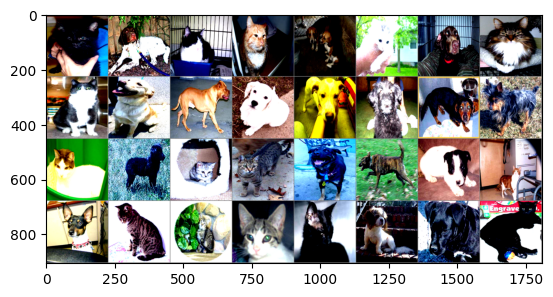

 cats  dogs  cats  cats  dogs  cats  dogs  cats  cats  dogs  dogs  dogs  dogs  dogs  dogs  dogs  cats  dogs  cats  cats  dogs  dogs  dogs  cats  dogs  cats  cats  cats  cats  dogs  dogs  cats


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % class_names[labels[j]] for j in range(32)))



In [21]:

from torchsummary import summary
model = net.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
summary(net, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 5,407,286
Trainable params: 5,407,286
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.49
Params size (MB): 20.63
Estimated Total Size (MB): 25.69
----------------------------------------------------------------


In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
def calculate_metrics(model, loader):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [24]:
def train_model(criterion, optimizer, batch_size, num_epochs):

  train_loss_list = []
  train_accuracy_list = []
  model = Net()

  for epoch in range(5):
      running_logg = 0.0
      for idx, data in enumerate(train_loader, 0):
          inputs, labels = data

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_logg += loss.item()


          if idx % 2000 == 1999:
              print(f'[{epoch+1}, {idx+1:5d}] loss: {running_logg/2000:.3f}')
              running_logg = 0.0
      train_loss, train_accuracy = calculate_metrics(model, train_loader)
      train_loss_list.append(train_loss)
      train_accuracy_list.append(train_accuracy)
      return train_loss_list, train_accuracy_list, model

In [25]:
import itertools

# Define hyperparameters and their search space
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
optimizers = [optim.SGD, optim.Adam, optim.Adagrad]
num_epochs = [5]

# Dictionary to store performance metrics for each hyperparameter combination
hyperparameter_metrics = {}

# Perform grid search
for lr, batch_size, optimizer_cls, num_epoch in itertools.product(learning_rates, batch_sizes, optimizers, num_epochs):
    optimizer = optimizer_cls(net.parameters(), lr=lr)

    train_loss_list, train_accuracy_list = train_model(criterion, optimizer, batch_size, num_epoch)

    # Evaluate model performance using validation set
    validation_loss, validation_accuracy = calculate_metrics(test_loader)

    # Store performance metrics for this hyperparameter combination
    hyperparameter_metrics[(lr, batch_size, optimizer_cls, num_epoch)] = {
        'train_loss_list': train_loss_list,
        'train_accuracy_list': train_accuracy_list,
        'validation_loss': validation_loss,
        'validation_accuracy': validation_accuracy
    }

# Choose best hyperparameters based on validation accuracy
best_hyperparameters = max(hyperparameter_metrics, key=lambda k: hyperparameter_metrics[k]['validation_accuracy'])
best_performance_metrics = hyperparameter_metrics[best_hyperparameters]

print("Best Hyperparameters:", best_hyperparameters)
print("Best Performance Metrics:", best_performance_metrics)


KeyboardInterrupt: 